# TC 5033
## Deep Learning
## Convolutional Neural Networks
<br>

#### Activity 2b: Building a CNN for CIFAR10 dataset with PyTorch
<br>

- Objective

    The main goal of this activity is to further your understanding of Convolutional Neural Networks (CNNs) by building one using PyTorch. You will apply this architecture to the famous CIFAR10 dataset, taking what you've learned from the guide code that replicated the Fully Connected model in PyTorch (Activity 2a).

- Instructions
    This activity requires submission in teams of 5 or 6 members. Submissions from smaller or larger teams will not be accepted unless prior approval has been granted (only due to exceptional circumstances). While teamwork is encouraged, each member is expected to contribute individually to the assignment. The final submission should feature the best arguments and solutions from each team member. Only one person per team needs to submit the completed work, but it is imperative that the names of all team members are listed in a Markdown cell at the very beginning of the notebook (either the first or second cell). Failure to include all team member names will result in the grade being awarded solely to the individual who submitted the assignment, with zero points given to other team members (no exceptions will be made to this rule).

    Understand the Guide Code: Review the guide code from Activity 2a that implemented a Fully Connected model in PyTorch. Note how PyTorch makes it easier to implement neural networks.

    Familiarize Yourself with CNNs: Take some time to understand their architecture and the rationale behind using convolutional layers.

    Prepare the Dataset: Use PyTorch's DataLoader to manage the dataset. Make sure the data is appropriately preprocessed for a CNN.

    Design the CNN Architecture: Create a new architecture that incorporates convolutional layers. Use PyTorch modules like nn.Conv2d, nn.MaxPool2d, and others to build your network.

    Training Loop and Backpropagation: Implement the training loop, leveraging PyTorch’s autograd for backpropagation. Keep track of relevant performance metrics.

    Analyze and Document: Use Markdown cells to explain your architectural decisions, performance results, and any challenges you faced. Compare this model with your previous Fully Connected model in terms of performance and efficiency.

- Evaluation Criteria

    - Understanding of CNN architecture and its application to the CIFAR10 dataset
    - Code Readability and Comments
    - Appropriateness and efficiency of the chosen CNN architecture
    - Correct implementation of Traning Loop and Accuracy Function
    - Model's performance metrics on the CIFAR10 dataset (at least 65% accuracy)
    - Quality of Markdown documentation

- Submission

Submit via Canvas your Jupyter Notebook with the CNN implemented in PyTorch. Your submission should include well-commented code and Markdown cells that provide a comprehensive view of your design decisions, performance metrics, and learnings.

### Download Cifar10 dataset

In [1]:
from torch.utils import data
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import v2


DATA_PATH = 'data'
MINIBATCH_SIZE = 128

transform_cifar = v2.Compose([
    v2.ToTensor(),
    v2.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])
])

# Train dataset
cifar10_data = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                                 transform=transform_cifar)
trainset, validationset = data.random_split(cifar10_data, [0.9, 0.1])
train_loader = DataLoader(trainset, batch_size=MINIBATCH_SIZE, shuffle=True)
val_loader = DataLoader(validationset, batch_size=MINIBATCH_SIZE, shuffle=True)

#Test set
cifar10_test = datasets.CIFAR10(DATA_PATH, train=False, download=True,
                                transform=transform_cifar)
test_loader = DataLoader(cifar10_test, batch_size=MINIBATCH_SIZE)

/home/diego/miniconda3/envs/mna_py_310/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified


### Using  GPUs

In [2]:
import torch


device = torch.device('cuda')

### Mostrar imágenes

La imagen muestreada representa un: bird


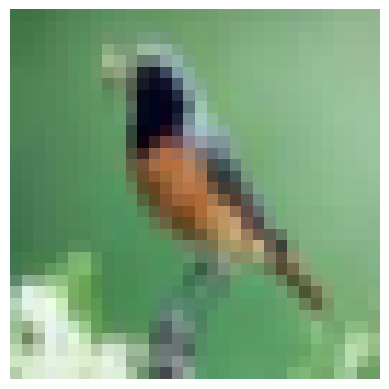

In [3]:
import matplotlib.pyplot as plt
import numpy as np


classes = test_loader.dataset.classes
def plot_figure(image):
    plt.imshow(np.transpose(image,(1,2,0)))
    plt.axis('off')
    plt.show()

rnd_sample_idx = np.random.randint(len(test_loader))
print(f'La imagen muestreada representa un: {classes[test_loader.dataset[rnd_sample_idx][1]]}')
image = test_loader.dataset[rnd_sample_idx][0]
image = (image - image.min()) / (image.max() -image.min() )
plot_figure(image)


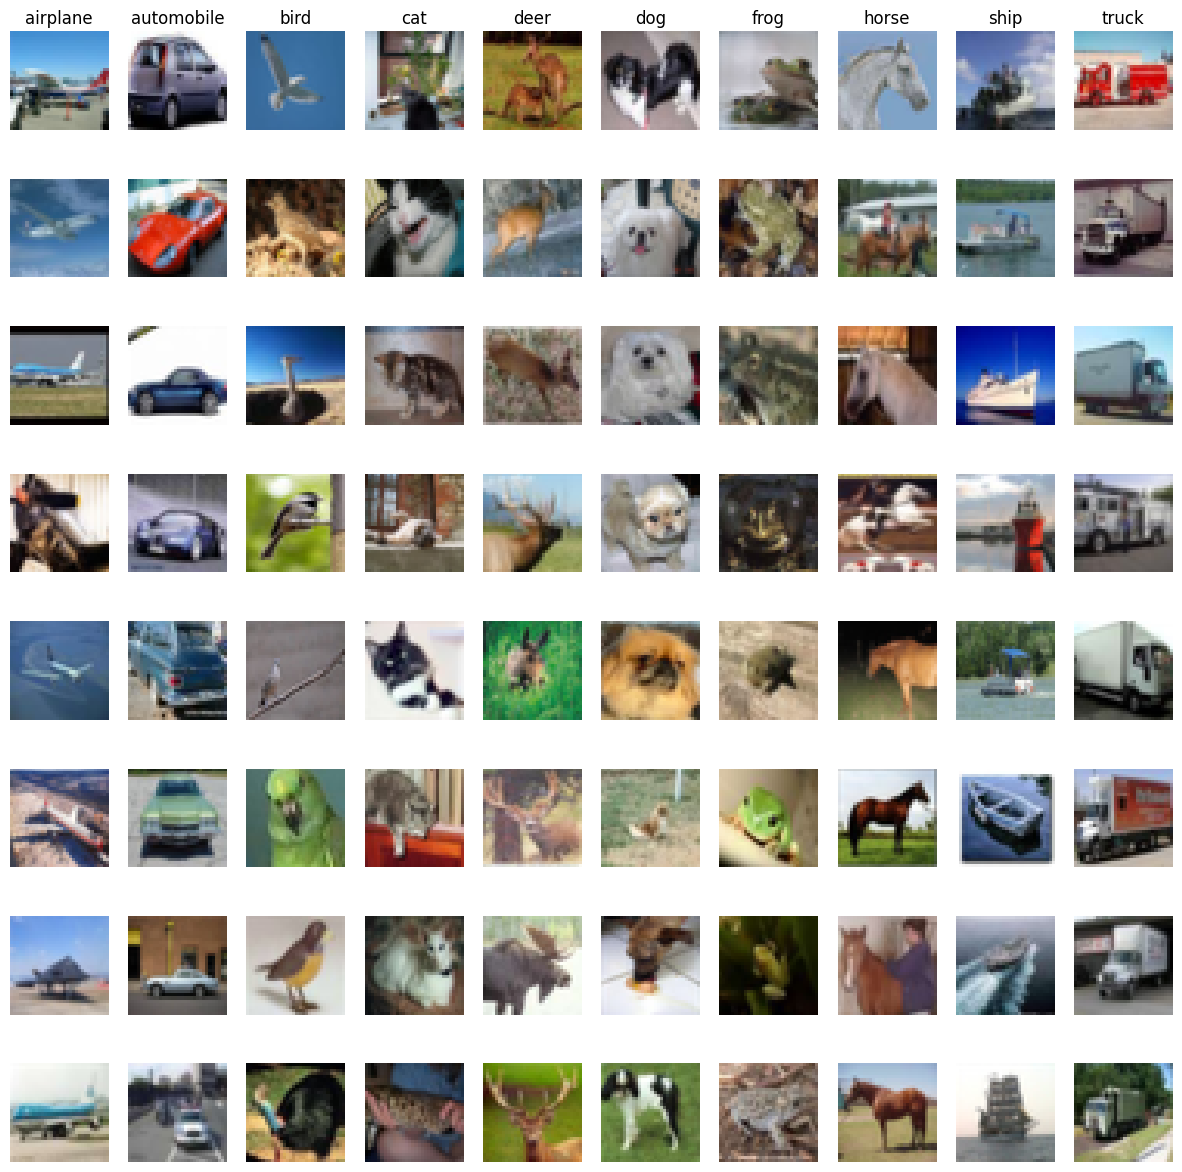

In [4]:
def plot_cifar10_grid():
    classes = test_loader.dataset.classes
    total_samples = 8
    plt.figure(figsize=(15,15))
    for label, sample in enumerate(classes):
        class_idxs = np.flatnonzero(label == np.array(test_loader.dataset.targets))
        sample_idxs = np.random.choice(class_idxs, total_samples, replace = False)
        for i, idx in enumerate(sample_idxs):
            plt_idx = i*len(classes) + label + 1
            plt.subplot(total_samples, len(classes), plt_idx)
            plt.imshow(test_loader.dataset.data[idx])
            plt.axis('off')
            
            if i == 0: plt.title(sample)
    plt.show()

plot_cifar10_grid() 

### Calcular accuracy


In [5]:
from torch.nn import CrossEntropyLoss, Module


def accuracy(model: Module, loader: DataLoader):
    criterion = CrossEntropyLoss()
    data_loss = 0
    true_positives = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            data_loss += loss.item()
            predictions = torch.max(outputs, 1).indices
            true_positives += torch.eq(predictions, labels).int().sum().cpu().item()
    data_loss /= len(loader)
    acc = true_positives / len(loader.dataset)
    return acc, data_loss

### Loop de entrenamiento

In [6]:
def train(model: Module, optimizer, epochs: int):
    criterion = CrossEntropyLoss()
    for epoch in range(epochs):
        train_loss = 0
        model.train()
        for data in train_loader:
            images, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        acc, val_loss = accuracy(model, val_loader)
        print(f"Epoch {epoch+1} - loss: {round(train_loss, 4)} - val_loss: {round(val_loss, 4)} - accuracy: {round(acc, 4)}")

### Linear model

In [7]:
from torch.nn import Sequential, Linear, ReLU, Flatten
from torch.optim.adam import Adam


linear_model = Sequential(
    Flatten(start_dim=1),
    Linear(3072, 1024),
    ReLU(),
    Linear(1024, 64),
    ReLU(),
    Linear(64, 10)
).to(device)

In [8]:
optimizer = Adam(linear_model.parameters(), 0.001)
train(linear_model, optimizer, 9)

Epoch 1 - loss: 1.6854 - val_loss: 1.5366 - accuracy: 0.4552
Epoch 2 - loss: 1.4792 - val_loss: 1.4242 - accuracy: 0.4912
Epoch 3 - loss: 1.3676 - val_loss: 1.4365 - accuracy: 0.4988
Epoch 4 - loss: 1.2878 - val_loss: 1.4623 - accuracy: 0.4972
Epoch 5 - loss: 1.2088 - val_loss: 1.3865 - accuracy: 0.5212
Epoch 6 - loss: 1.1409 - val_loss: 1.4103 - accuracy: 0.5094
Epoch 7 - loss: 1.0843 - val_loss: 1.4169 - accuracy: 0.5124
Epoch 8 - loss: 1.0202 - val_loss: 1.4545 - accuracy: 0.527
Epoch 9 - loss: 0.9509 - val_loss: 1.5005 - accuracy: 0.5202


### Sequential CNN

In [9]:
from torch.nn import Conv2d, MaxPool2d, BatchNorm2d

cnn_model = Sequential(
    Conv2d(3, 64, kernel_size=3, padding=1),
    BatchNorm2d(64),
    ReLU(),
    Conv2d(64, 256, kernel_size=3, stride=2, padding=1),
    BatchNorm2d(256),
    ReLU(),
    Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
    BatchNorm2d(512),
    ReLU(),
    Conv2d(512, 1024, kernel_size=3, stride=2, padding=1),
    BatchNorm2d(1024),
    ReLU(),
    Conv2d(1024, 2048, kernel_size=3, stride=2, padding=1),
    BatchNorm2d(2048),
    ReLU(),
    MaxPool2d(kernel_size=3, stride=2, padding=1),
    Flatten(),
    Linear(2048, 10),
).to(device)

In [10]:
optimizer = Adam(cnn_model.parameters(), 0.001)
train(cnn_model, optimizer, 9)

Epoch 1 - loss: 1.4437 - val_loss: 1.0483 - accuracy: 0.625
Epoch 2 - loss: 0.9099 - val_loss: 0.9471 - accuracy: 0.6716
Epoch 3 - loss: 0.6596 - val_loss: 0.7099 - accuracy: 0.7628
Epoch 4 - loss: 0.4585 - val_loss: 0.6946 - accuracy: 0.7712
Epoch 5 - loss: 0.2944 - val_loss: 0.7318 - accuracy: 0.7734
Epoch 6 - loss: 0.1723 - val_loss: 0.8295 - accuracy: 0.7684
Epoch 7 - loss: 0.097 - val_loss: 0.8355 - accuracy: 0.783
Epoch 8 - loss: 0.0727 - val_loss: 0.9375 - accuracy: 0.7876
Epoch 9 - loss: 0.0779 - val_loss: 0.9272 - accuracy: 0.7882


## Evaluation

In [11]:
acc, _ = accuracy(linear_model, test_loader)
acc

0.5157

In [12]:
acc, _ = accuracy(cnn_model, test_loader)
acc

0.7698